In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import xesmf as xe
import dask
import matplotlib.pyplot as plt 
import matplotlib
from dask_jobqueue import PBSCluster
from dask.distributed import Client

import fates_calibration_library.analysis_functions as analysis
import fates_calibration_library.biome_functions as biomes
import fates_calibration_library.utils as utils
import fates_calibration_library.plotting_functions as plotting

In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='06:00:00',                                       # Amount of wall time
    interface='ext') 

In [3]:
cluster.scale(30)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.176:44389,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
# CLM simulation to get TSA, RAIN, and SNOW
clm_sim_dir = os.path.join("/glade/derecho/scratch/afoster/archive",
                            "ctsm60SP_bigleaf_fullgrid/lnd/hist")

# elevation
elev = xr.open_dataset(os.path.join('/glade/work/afoster/FATES_calibration',
                                    'observations/elev.1-deg.nc'),
                       decode_times=False)
elev = elev.isel(time=0)

land_frac_ds = os.path.join(clm_sim_dir, "ctsm60SP_bigleaf_fullgrid.clm2.h0.0001-02-01-00000.nc")
target_grid = analysis.create_target_grid(land_frac_ds, 'FSR')

holdridge_dat = pd.read_csv('/glade/work/afoster/FATES_calibration/observations/holdridge_climates.csv')

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/xarray/coding/times.py:167: SerializationWarning: Ambiguous reference date string: 1- 1- 1  1: 0: 1. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001- 1- 1  1: 0: 1). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [5]:
# regrid elevation
regridder = xe.Regridder(elev, target_grid, 'conservative')
elev_regrid = regridder(elev)

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [6]:
clm_ds = biomes.read_in_clm_sim(clm_sim_dir)

In [8]:
clim_dat = biomes.get_holdridge_dat(clm_ds, elev_regrid.data)

In [63]:
np.unique(clim_dat.latitude_ind)

array([0, 1, 2, 3, 4, 5])

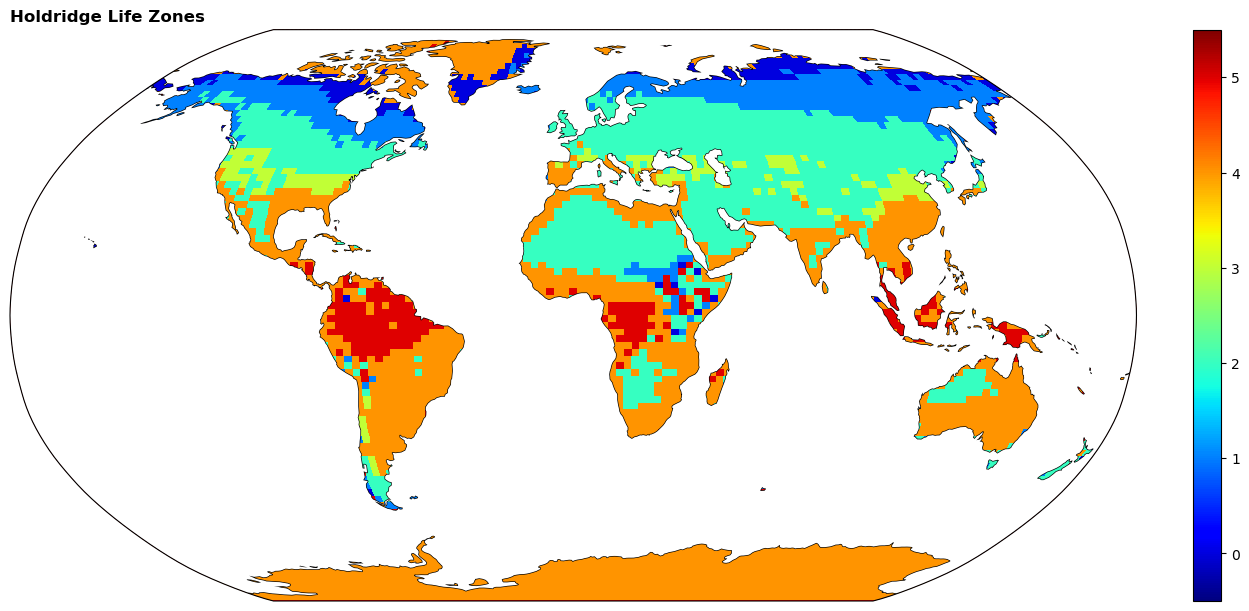

In [64]:
figure, axes = plotting.generate_subplots(1)
pcm = plotting.map_function(axes[0], clim_dat.latitude_ind,
                            "Holdridge Life Zones", 'jet', -0.5, 5.5)
cbar = figure.colorbar(pcm, ax=axes[0], fraction=0.03, orientation="vertical")

In [2]:
import importlib
import fates_calibration_library.biome_functions
importlib.reload(fates_calibration_library.biome_functions)

<module 'fates_calibration_library.biome_functions' from '/glade/work/afoster/FATES_calibration/fates_calibration_library/fates_calibration_library/biome_functions.py'>

In [9]:
def classify_holdridge(clim_dat, holdridge_dat):
    
    clim_flat = clim_dat.stack(grid=('lat', 'lon'))
    
    # convert holdridge columns to np arrays
    hold_pet = holdridge_dat['PET_ratio'].values 
    hold_lat = holdridge_dat['latitude_zone'].values
    hold_precip = holdridge_dat['precip'].values
    
    # get CLM data
    pet_vals = clim_flat['pet_ratio'].values[:, np.newaxis] 
    lat_vals = clim_flat['latitude_region_ind'].values[:, np.newaxis]
    precip_vals = clim_flat['precipitation'].values[:, np.newaxis]
    
    # compute euclidean distance
    pet_dist = (pet_vals - hold_pet) ** 2
    lat_dist = (lat_vals - hold_lat) ** 2
    precip_dist = (precip_vals - hold_precip) ** 2
    total_dist = pet_dist + lat_dist + precip_dist  
    
    # find best match per grid cell
    best_idx = np.argmin(total_dist, axis=1)
    biome_labels = holdridge_dat['biome'].values[best_idx]

    biome_da = xr.DataArray(
        biome_labels.reshape(clim_dat['pet_ratio'].shape),
        coords=clim_dat['pet_ratio'].coords,
        dims=clim_dat['pet_ratio'].dims,
        name='holdridge_biome'
    )
    
    return biome_da

In [49]:
np.unique(clim_dat.holdridge_zone)

array(['cool temperate desert', 'cool temperate dry scrub',
       'cool temperate dry tundra', 'cool temperate moist forest',
       'cool temperate moist tundra', 'cool temperate rain forest',
       'cool temperate wet forest', 'polar desert', 'polar dry forest',
       'polar dry tundra', 'polar rain forest', 'polar rain tundra',
       'polar thorn woodland', 'polar very dry forest',
       'polar wet tundra', 'subpolar desert', 'subpolar dry scrub',
       'subpolar moist tundra', 'subpolar rain forest',
       'subpolar rain tundra', 'subpolar very dry forest',
       'subpolar wet tundra', 'subtropical desert',
       'subtropical desert scrub', 'subtropical dry forest',
       'subtropical dry scrub', 'subtropical dry tundra',
       'subtropical moist forest', 'subtropical rain forest',
       'subtropical steppe', 'subtropical thorn woodland',
       'subtropical very dry forest', 'subtropical wet forest',
       'tropical desert', 'tropical dry forest', 'tropical dry scrub'

In [10]:
clim_dat['biome'] = classify_holdridge(clim_dat, holdridge_dat)

In [37]:
def join_nonempty(*parts):
    return " ".join(p for p in parts if p and p.strip())

holdridge_zone = xr.apply_ufunc(
    join_nonempty,
    clim_dat["latitude_zone"],
    #clim_dat["altitude_zone"],
    clim_dat["biome"],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[str]
)

In [38]:
clim_dat['holdridge_zone'] = holdridge_zone

In [50]:
# zone_names = np.unique(holdridge_zone.values)
# zone_to_code = {name: i for i, name in enumerate(holdridge_dat.region)}
# holdridge_code = xr.apply_ufunc(
#     lambda z: zone_to_code[z],
#     holdridge_zone,
#     vectorize=True,
#     dask="parallelized",
#     output_dtypes=[int]
# )

In [53]:
sub = clim_dat.where(clim_dat.holdridge_zone == 'subtropical steppe')

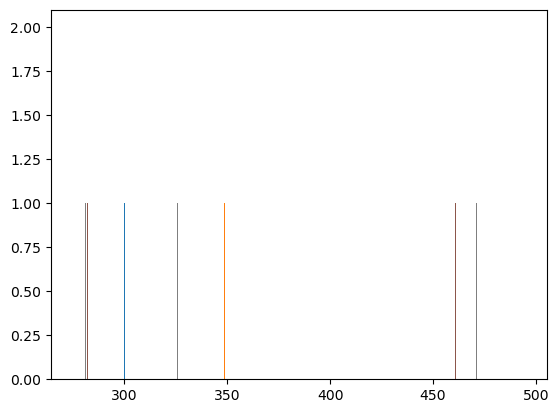

In [60]:
plt.hist(sub.precipitation.values);

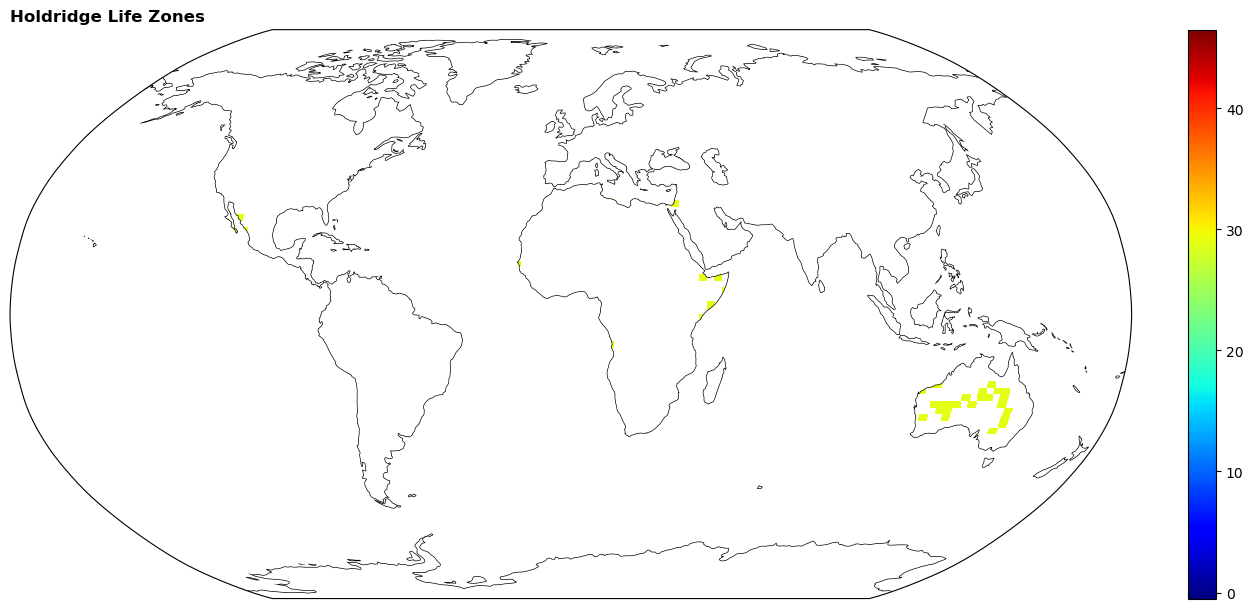

In [52]:

figure, axes = plotting.generate_subplots(1)
pcm = plotting.map_function(axes[0], sub.holdridge_code,
                            "Holdridge Life Zones", 'jet', -0.5, len(np.unique(clim_dat.holdridge_code))+0.5)
cbar = figure.colorbar(pcm, ax=axes[0], fraction=0.03, orientation="vertical")
#cbar.set_label("Life Zone", size=12, fontweight="bold")
#cbar.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#cbar.set_ticklabels(names)